In [2]:
import os
import gc
import glob

import numpy as np 
import pandas as pd 

from itertools import islice

from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# import tensorflow as tf
# from tensorflow import keras
# import tensorflow.keras.backend as K
import torch
from torch import nn
import torch.nn.functional as F


# from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate
# from tensorflow.keras.layers import Layer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm.auto import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

In [1]:
import psutil
psutil.cpu_count()

16

In [3]:
NTHREADS = psutil.cpu_count()-2
SEED = 42
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
BUCKET_WINDOWS2 = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, 600)]

DATA_PATH = 'input/optiver-realized-volatility-prediction'
BOOK_TRAIN_PATH = 'input/optiver-realized-volatility-prediction/book_train.parquet'
TRADE_TRAIN_PATH = 'input/optiver-realized-volatility-prediction/trade_train.parquet'
BOOK_TEST_PATH = 'input/optiver-realized-volatility-prediction/book_test.parquet'
TRADE_TEST_PATH = 'input/optiver-realized-volatility-prediction/trade_test.parquet'
CHECKPOINT = 'model_checkpoint/model_01'

book_skip_columns = trade_skip_columns = ['time_id', 'row_id', 'target']

In [4]:
import pickle
data_input = open('LSTMtemp/np_train.pkl','rb')
np_train = pickle.load(data_input)
data_input.close()

data_input = open('LSTMtemp/targets.pkl','rb')
targets = pickle.load(data_input)
data_input.close()

In [5]:
idx = np.arange(np_train.shape[0])
train_idx, valid_idx = train_test_split(idx, shuffle=False, test_size=0.1, random_state=2021)

# Scaler
transformers = []
for i in tqdm(range(np_train.shape[1])):
    a = np.nan_to_num(np_train[train_idx, i, :])
    b = np.nan_to_num(np_train[valid_idx, i, :])

    transformer = StandardScaler() # StandardScaler is very useful!
    np_train[train_idx, i, :] = transformer.fit_transform(a)
    np_train[valid_idx, i, :] = transformer.transform(b)
    transformers.append(transformer) # Save Scalers for the inference stage

np_train = np.nan_to_num(np_train)

import pickle
data_output = open('LSTMtemp/np_train.pkl','wb')
pickle.dump(np_train,data_output)
data_output.close()

data_output = open('LSTMtemp/targets.pkl','wb')
pickle.dump(targets,data_output)
data_output.close()

In [6]:
# Loss function
def rmspe(y_true, y_pred):
    return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, ds, y):
        super().__init__()
        self.ds = ds
        self.y = y

    def __len__(self):
        return self.ds.shape[0]

    def __getitem__(self, idx):
        x = self.ds[idx]
        y = self.y[idx]
        return x, y

In [14]:
class MyGRU(nn.Module):
    def __init__(self,hidden_size, n_layers=1, dim_f=29):
        super(MyGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dim_f = dim_f
#         self.w_omega = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
#         self.u_omega = nn.Parameter(torch.Tensor(hidden_size, 1))
#         nn.init.uniform_(self.w_omega, -0.01, 0.01)
#         nn.init.uniform_(self.u_omega, -0.01, 0.01)
        
        self.lstm = nn.GRU(input_size = dim_f,
                    hidden_size = hidden_size,
                    num_layers = n_layers
                   )
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(hidden_size*1, 1)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(512,1)
        
        
    def attention(self, x):
        u = torch.tanh(torch.matmul(x, self.w_omega))
        attn = torch.matmul(u, self.u_omega)
        attn_score = F.softmax(attn, dim =1)
        scored_x = x * attn_score
        context = torch.sum(scored_x ,dim=1)
        return context
        
        
    def forward(self,x):
        x.transpose_(1, 0)
        x, h_n = self.lstm(x)
        x = h_n.permute(1, 0 ,2)
#         attn_output = self.attn(x)
        x = self.flat(x)
#         x = torch.cat((attn_output,x),1)
        x = self.fc1(x)
        return x

In [15]:
class Myloss(nn.Module):
    def __init__(self):
        super(Myloss, self).__init__()
    
    def forward(self, y_true, y_pred):
        x = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
        return x

In [18]:
Batch_size = 1024 * 5
train_dataset = MyDataset(np_train[train_idx, :, :], targets[train_idx])
test_dataset = MyDataset(np_train[valid_idx, :, :], targets[valid_idx])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = Batch_size,num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = Batch_size,num_workers = 0)

assert torch.cuda.is_available()
device = 'cuda'

hidden_size = 50
n_layers =1
lr = 0.006

model = MyGRU(hidden_size=hidden_size, n_layers=n_layers)
model.to(device)

criterion = Myloss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = lr)
print(model)

MyGRU(
  (lstm): GRU(29, 50)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50, out_features=1, bias=True)
)


In [21]:
np_train

array([[[ 0.0000e+00,  7.3730e-01,  8.6279e-01, ..., -1.4612e-01,
          9.0186e-01, -5.5939e-02],
        [ 4.1870e-02,  8.6182e-01,  9.1992e-01, ..., -5.5756e-02,
          2.5742e-02, -2.9297e-01],
        [-3.5840e-01,  8.3740e-01,  9.2725e-01, ...,  3.3667e-01,
          1.4131e+00, -1.2018e-01],
        ...,
        [-6.8164e-01,  5.0195e-01,  4.6118e-01, ..., -3.2990e-02,
          4.1821e-01,  6.1328e-01],
        [-7.2900e-01,  6.0254e-01,  6.6406e-01, ..., -1.0724e-01,
          2.1069e-01, -1.8787e-01],
        [-5.5713e-01, -5.4834e-01, -5.4639e-01, ..., -3.1836e-01,
         -1.8835e-01, -4.4360e-01]],

       [[ 0.0000e+00,  2.3792e-01,  1.7444e-01, ..., -1.4612e-01,
          5.2051e-01, -6.0211e-02],
        [-8.3359e+00, -3.5205e-01, -4.0942e-01, ..., -4.7900e-01,
         -3.3105e-01, -3.5474e-01],
        [-1.7373e+00, -4.9133e-02, -1.3098e-01, ..., -9.8828e-01,
          2.3840e-01, -1.7712e-01],
        ...,
        [-6.8164e-01, -5.9863e-01, -3.7061e-01, ..., -

In [19]:
print("""The Hyperparameter:
      Hidden_size = {}
      n_layers = {}
      Learnning rate = {}
      """.format(hidden_size,n_layers, lr))
train_loss = []
val_loss = []
best_loss = float('+inf')
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()

epochs = 100
counter = 0

for epoch in tqdm(range(epochs)):
    model.train()
    avg_loss = []
    for x,y in train_loader:
        x = x.float()
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(y,output)
        avg_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    avg_loss = np.array(avg_loss).mean()
    train_loss.append(avg_loss)
    
    model.eval()
    val_aloss = []
    with torch.no_grad():
        for x,y in test_loader:
            x = x.float()
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = criterion(y, output)
            val_aloss.append(loss.item())
        val_aloss = np.array(val_aloss).mean()
        val_loss.append(val_aloss)
    
    if val_aloss <best_loss:
        best_loss = val_aloss
        best_epoch = epoch
        torch.save(model.state_dict(), 'MyLStm_model.pt')
        counter = 0
    counter += 1
    if counter >= 9:
        print('连续{}个epoch没有下降了'.format(counter))
    print('Epoch:  {}   |Train_Loss: {:.6f} |Val_Loss: {:.6f}'.format(epoch + 1,avg_loss,val_aloss))

The Hyperparameter:
      Hidden_size = 50
      n_layers = 1
      Learnning rate = 0.006
      


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  1   |Train_Loss: 20.615730 |Val_Loss: 7.923088
Epoch:  2   |Train_Loss: 11.317620 |Val_Loss: 4.230502
Epoch:  3   |Train_Loss: 2.189142 |Val_Loss: 2.341012
Epoch:  4   |Train_Loss: 1.786664 |Val_Loss: 1.539948
Epoch:  5   |Train_Loss: 1.147261 |Val_Loss: 1.291233
Epoch:  6   |Train_Loss: 1.316142 |Val_Loss: 1.690530
Epoch:  7   |Train_Loss: 1.483370 |Val_Loss: 1.057308
Epoch:  8   |Train_Loss: 0.949667 |Val_Loss: 0.640409
Epoch:  9   |Train_Loss: 1.526880 |Val_Loss: 1.033922
Epoch:  10   |Train_Loss: 1.594140 |Val_Loss: 0.973621
Epoch:  11   |Train_Loss: 0.799504 |Val_Loss: 0.655258
Epoch:  12   |Train_Loss: 1.398846 |Val_Loss: 0.854176
Epoch:  13   |Train_Loss: 1.013826 |Val_Loss: 0.594949
Epoch:  14   |Train_Loss: 0.651893 |Val_Loss: 0.599415
Epoch:  15   |Train_Loss: 0.924562 |Val_Loss: 0.607906
Epoch:  16   |Train_Loss: 0.750206 |Val_Loss: 0.692359
Epoch:  17   |Train_Loss: 0.847324 |Val_Loss: 0.635631
Epoch:  18   |Train_Loss: 0.956724 |Val_Loss: 0.703129
Epoch:  19   |Tra

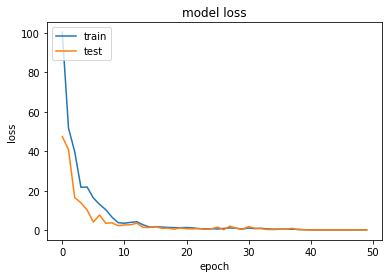

Min val_loss is: 0.2464742437005043 at 49 epoch


In [82]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','test'], loc = 'upper left')
plt.show()
print('Min val_loss is:',best_loss,'at',best_epoch,'epoch')

In [ ]:
a = np.min(history.history['val_loss'])
print(f'The best val_loss is {a:.4f}')

In [ ]:
del np_train, np_books, np_trades
z = gc.collect()

In [ ]:
%%time
pool = Pool(NTHREADS)
r = pool.map(process_book_test_chunk, book_test_chunks)
pool.close()

a1, _ = zip(*r)
np_books = [np.concatenate(a1[i], axis=0) for i in range(len(a1))]
np_books = np.concatenate(np_books, axis=0)

In [ ]:
%%time
pool = Pool(NTHREADS)
r = pool.map(process_trade_test_chunk, trade_test_chunks)
pool.close()

a1, _ = zip(*r)
np_trades = [np.concatenate(a1[i], axis=0) for i in range(len(a1))]
np_trades = np.concatenate(np_trades, axis=0)

In [ ]:
print(np_books.shape, np_trades.shape)
np_test = np.concatenate((np_books, np_trades), axis=2)
print(np_test.shape)

In [ ]:
# Scaler
for i in tqdm(range(np_test.shape[1])):
    transformer = transformers[i]
    np_test[:, i, :] = transformer.transform(np.nan_to_num(np_test[:, i, :]))


In [ ]:
np_test = np.nan_to_num(np_test)

In [ ]:
model.load_weights(checkpoint_filepath)
res = model.predict(np_test, batch_size=TEST_BATCH_SIZE)
res = np.clip(res, 0, 1)

In [ ]:
import shutil
shutil.rmtree('./model_checkpoint')